In [1]:
from matplotlib import pyplot as plt
import torch

In [8]:
from groundingdino.util.inference import load_model, load_image, predict, annotate
import cv2

model = load_model("groundingdino/config/GroundingDINO_SwinT_OGC.py", "weights/groundingdino_swint_ogc.pth")
IMAGE_PATH = "0000034.jpg"
TEXT_PROMPT = "ground"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD,
    device='cuda'
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
cv2.imwrite("annotated_image.jpg", annotated_frame)

final text_encoder_type: bert-base-uncased


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


True

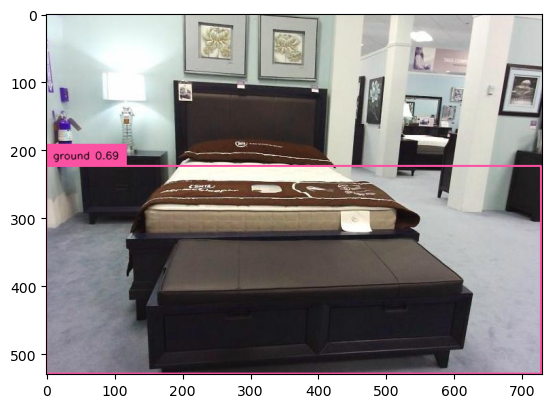

In [4]:
plt.imshow(annotated_frame)

In [3]:
boxes

tensor([[0.4999, 0.7108, 0.9972, 0.5753]])

In [4]:
def plot_results(pil_img, scores, labels, boxes, text):
    # colors for visualization
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax), c in zip(scores, labels, boxes, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        label = f'{text}: {score:0.2f}'
        ax.text(xmin, ymin, label, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [5]:
from transformers import GroundingDinoProcessor
from transformers import GroundingDinoForObjectDetection
from PIL import Image

processor = GroundingDinoProcessor.from_pretrained("IDEA-Research/grounding-dino-tiny")
model = GroundingDinoForObjectDetection.from_pretrained("IDEA-Research/grounding-dino-tiny")

text = "ground"

image = Image.open(IMAGE_PATH)

def preprocess_caption(caption: str) -> str:
    result = caption.lower().strip()
    if result.endswith("."):
        return result
    return result + "."

inputs = processor(images=image, text=preprocess_caption(TEXT_PROMPT), return_tensors="pt")

Could not load the custom kernel for multi-scale deformable attention: [Errno 2] No such file or directory: 'C:\\Users\\Andre\\miniconda3\\Lib\\site-packages\\transformers\\kernels\\grounding_dino\\vision.cpp'
Could not load the custom kernel for multi-scale deformable attention: [Errno 2] No such file or directory: 'C:\\Users\\Andre\\miniconda3\\Lib\\site-packages\\transformers\\kernels\\grounding_dino\\vision.cpp'
Could not load the custom kernel for multi-scale deformable attention: [Errno 2] No such file or directory: 'C:\\Users\\Andre\\miniconda3\\Lib\\site-packages\\transformers\\kernels\\grounding_dino\\vision.cpp'
Could not load the custom kernel for multi-scale deformable attention: [Errno 2] No such file or directory: 'C:\\Users\\Andre\\miniconda3\\Lib\\site-packages\\transformers\\kernels\\grounding_dino\\vision.cpp'
Could not load the custom kernel for multi-scale deformable attention: [Errno 2] No such file or directory: 'C:\\Users\\Andre\\miniconda3\\Lib\\site-packages\\t

In [6]:
with torch.no_grad():
  outputs = model(**inputs)

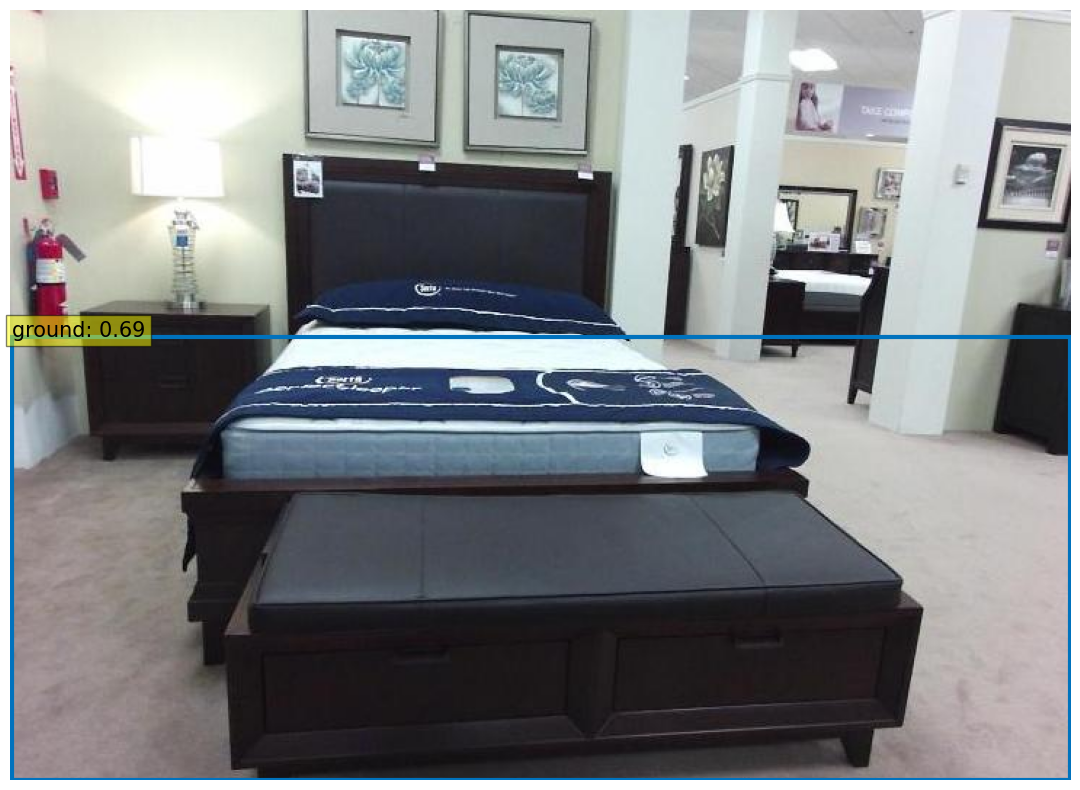

In [8]:
#  postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.image_processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.3)
results = postprocessed_outputs[0]
     
plot_results(image, results['scores'].tolist(), results['labels'].tolist(), results['boxes'].tolist(), text)

In [26]:
from transformers import pipeline

pipe = pipeline(task="zero-shot-object-detection", model="IDEA-Research/grounding-dino-tiny")

results = pipe(IMAGE_PATH, candidate_labels=[preprocess_caption(text)], threshold=0.3)

print(results)

[{'score': 0.6072642803192139, 'label': 'chair . person . dog .', 'box': {'xmin': 0, 'ymin': 319, 'xmax': 562, 'ymax': 878}}, {'score': 0.5399560928344727, 'label': 'chair . person . dog .', 'box': {'xmin': 397, 'ymin': 11, 'xmax': 1139, 'ymax': 899}}]


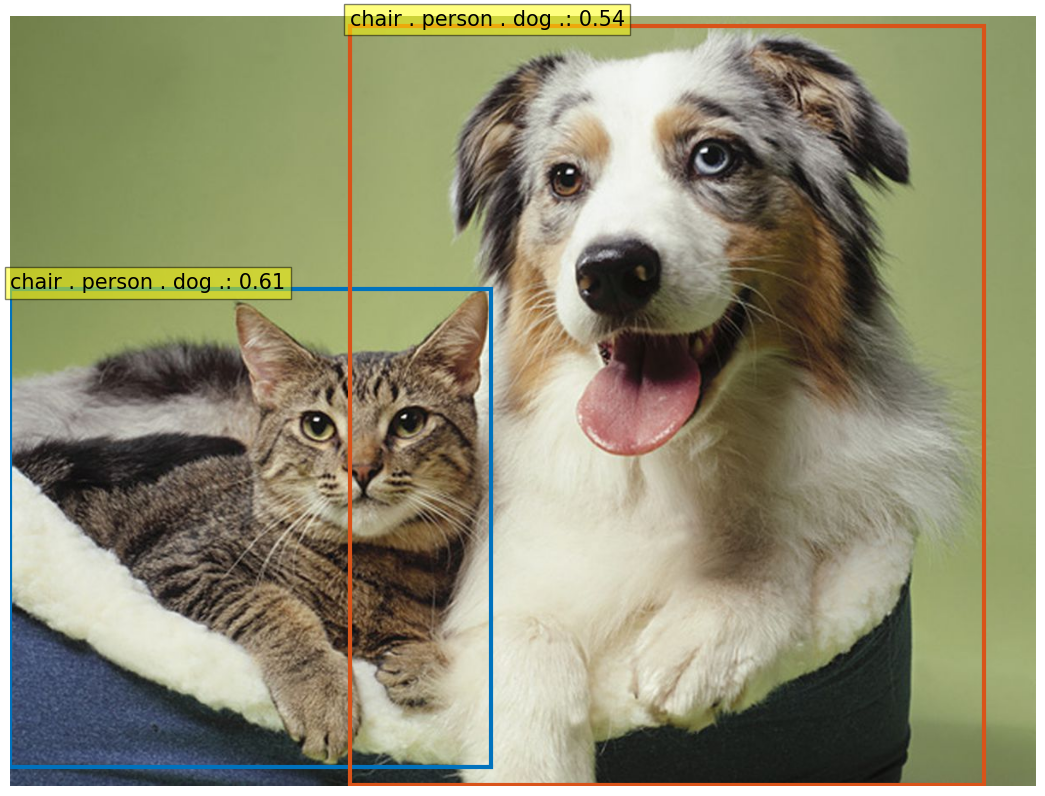

In [27]:
scores, labels, boxes = [], [], []
for result in results:
  scores.append(result["score"])
  labels.append(result["label"])
  boxes.append(tuple(result["box"].values()))

plot_results(image, scores, labels, boxes, text)

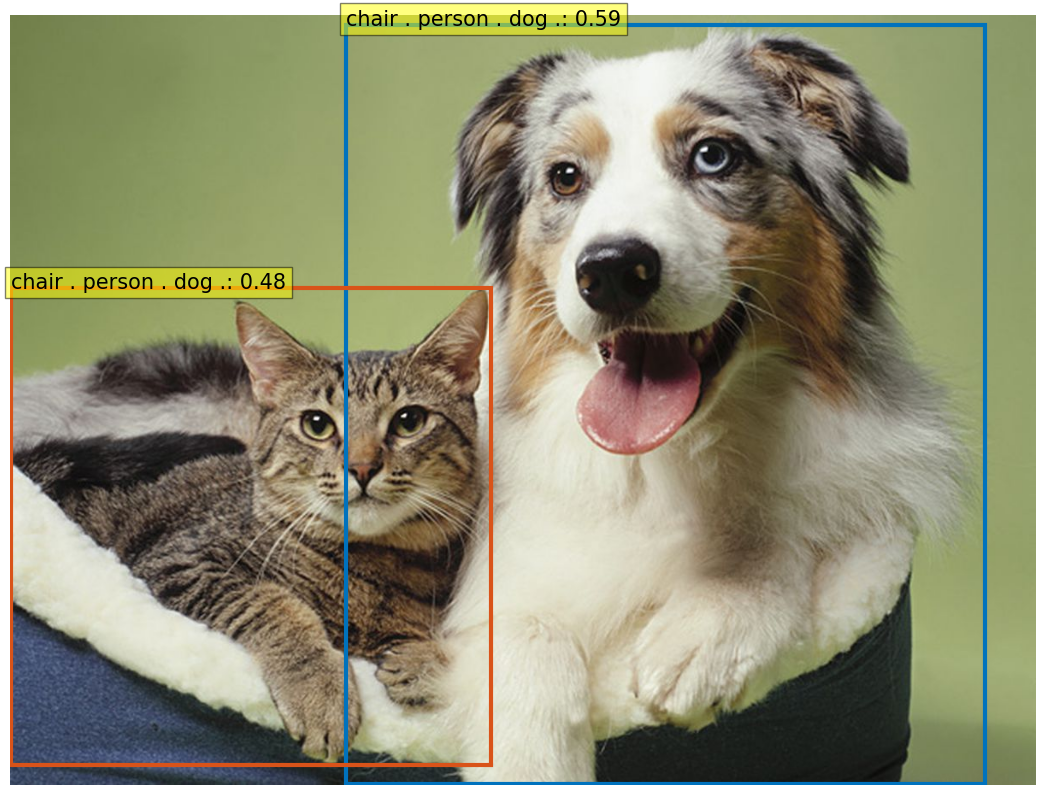

In [28]:
# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.post_process_grounded_object_detection(outputs,
                                                                input_ids=inputs.input_ids,
                                                                target_sizes=[(height, width)],
                                                                box_threshold=0.3,
                                                                text_threshold=0.1)
results = postprocessed_outputs[0]
     

plot_results(image, results['scores'], results['labels'], results['boxes'], text)